In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Pothole-dataset/pothole_dataset.zip'  #Change the zip file name as needed

Archive:  /content/drive/MyDrive/Pothole-dataset/pothole_dataset.zip
   creating: pothole_dataset/normal/
  inflating: pothole_dataset/normal/1.jpg  
  inflating: pothole_dataset/normal/10.jpg  
  inflating: pothole_dataset/normal/100.jpg  
  inflating: pothole_dataset/normal/101.jpg  
  inflating: pothole_dataset/normal/102.jpg  
  inflating: pothole_dataset/normal/103.jpg  
  inflating: pothole_dataset/normal/104.jpg  
  inflating: pothole_dataset/normal/105.jpg  
  inflating: pothole_dataset/normal/106.jpg  
  inflating: pothole_dataset/normal/107.jpg  
  inflating: pothole_dataset/normal/108.jpg  
  inflating: pothole_dataset/normal/109.jpg  
  inflating: pothole_dataset/normal/11.jpg  
  inflating: pothole_dataset/normal/110.jpg  
  inflating: pothole_dataset/normal/111.jpg  
  inflating: pothole_dataset/normal/112.jpg  
  inflating: pothole_dataset/normal/113.jpg  
  inflating: pothole_dataset/normal/114.jpg  
  inflating: pothole_dataset/normal/115.jpg  
  inflating: pothole_dat

In [13]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from glob import glob
from keras.applications.vgg16 import VGG16

In [14]:
# Define constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001


In [15]:
# Initialize lists to store images and labels
X = []
y = []

In [16]:
# Define variables to keep track of image counts for each label
potholes_count = 0
normal_count = 0

In [17]:
def load_and_preprocess_data(data_dir, label, img_size=(IMG_SIZE, IMG_SIZE)):
    image_paths = glob(os.path.join(data_dir, '*.jpg'))
    count = 0  # Initialize the count for this label
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is not None:  # Check if the image was loaded successfully
            img = cv2.resize(img, img_size)
            img = preprocess_input(img)
            X.append(img)
            y.append(label)
            count += 1  # Increment the count for this label
        else:
            print(f"Failed to load image: {image_path}")
    return count


In [18]:
# Load and preprocess the dataset
pothole_dir = 'pothole_dataset/potholes'
plain_dir = 'pothole_dataset/normal'

potholes_count = load_and_preprocess_data(pothole_dir, label='POTHOLES')
normal_count = load_and_preprocess_data(plain_dir, label='NORMAL')

# Print the counts
print('Number of POTHOLES images:', potholes_count)
print('Number of NORMAL images:', normal_count)

Failed to load image: pothole_dataset/normal/226.jpg
Number of POTHOLES images: 329
Number of NORMAL images: 351


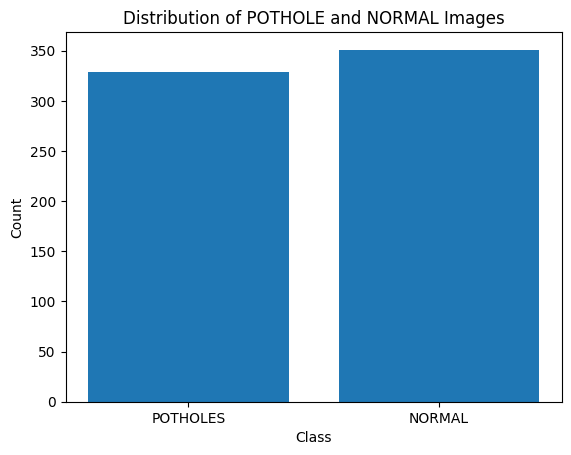

In [19]:
# Data
labels = ['POTHOLES', 'NORMAL']
counts = [potholes_count, normal_count]

# Create a bar plot
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of POTHOLE and NORMAL Images')

# Display the plot
plt.show()

In [20]:
# Encode labels with explicit class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = ['NORMAL', 'POTHOLES']
y_encoded = to_categorical(y_encoded, num_classes=len(class_labels))

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Count the number of samples for each class in the training and testing datasets
train_class_counts = [sum(y_train[:, 0] == 1), sum(y_train[:, 1] == 1)]
test_class_counts = [sum(y_test[:, 0] == 1), sum(y_test[:, 1] == 1)]

print("Training Class Counts:", train_class_counts)
print("Testing Class Counts:", test_class_counts)

Training Class Counts: [680, 922]
Testing Class Counts: [171, 230]


In [22]:
# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [23]:
# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 [==============================] - 2s 0us/step


In [24]:
# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Define callbacks for model training
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)


In [26]:
# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 17.2697 - accuracy: 0.5515 
Epoch 1: val_accuracy improved from -inf to 0.45588, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 434s 25s/step - loss: 17.2697 - accuracy: 0.5515 - val_loss: 0.7298 - val_accuracy: 0.4559
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.5423 
Epoch 2: val_accuracy did not improve from 0.45588
17/17 [==============================] - 427s 25s/step - loss: 0.7003 - accuracy: 0.5423 - val_loss: 0.7932 - val_accuracy: 0.3971
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5239 
Epoch 3: val_accuracy did not improve from 0.45588
17/17 [==============================] - 424s 25s/step - loss: 0.6934 - accuracy: 0.5239 - val_loss: 0.7432 - val_accuracy: 0.3971
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.5368 
Epoch 4: val_accuracy did not improve from 0.45588
17/17 [==============================] - 423s 25s/step - loss: 0.8082 - accuracy: 0.5368 - val_loss: 0.7041 - val_accuracy: 0.4044
Epoch 5/30
17/17 [===================

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 88.24%


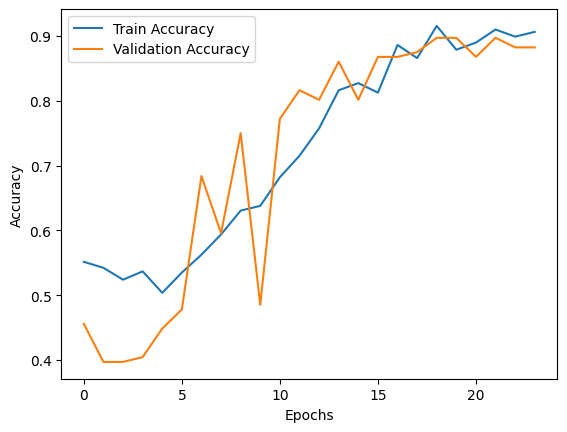

In [28]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)
print(y_pred)

5/5 [==============================] - 32s 5s/step
[[9.99049127e-01 9.50809685e-04]
 [9.99850512e-01 1.49435466e-04]
 [1.22769954e-04 9.99877214e-01]
 [6.47671372e-02 9.35232878e-01]
 [4.20855329e-04 9.99579132e-01]
 [9.99248266e-01 7.51807413e-04]
 [1.59020927e-02 9.84097838e-01]
 [2.33191997e-03 9.97668087e-01]
 [3.26955825e-01 6.73044264e-01]
 [9.99290943e-01 7.09087006e-04]
 [9.48940635e-01 5.10593243e-02]
 [9.99908388e-01 9.16025165e-05]
 [2.74668068e-01 7.25331962e-01]
 [9.99174654e-01 8.25268915e-04]
 [3.29560507e-03 9.96704400e-01]
 [1.01204310e-03 9.98987913e-01]
 [8.77104223e-01 1.22895777e-01]
 [4.81683575e-03 9.95183110e-01]
 [3.61995958e-03 9.96379912e-01]
 [1.89524505e-03 9.98104632e-01]
 [9.99889195e-01 1.10750065e-04]
 [3.34949512e-03 9.96650398e-01]
 [6.73598377e-03 9.93263960e-01]
 [4.68778431e-01 5.31221569e-01]
 [4.77413595e-01 5.22586286e-01]
 [2.95224823e-02 9.70477581e-01]
 [7.71557679e-03 9.92284477e-01]
 [9.56624806e-01 4.33751754e-02]
 [1.95146084e-03 9.980484

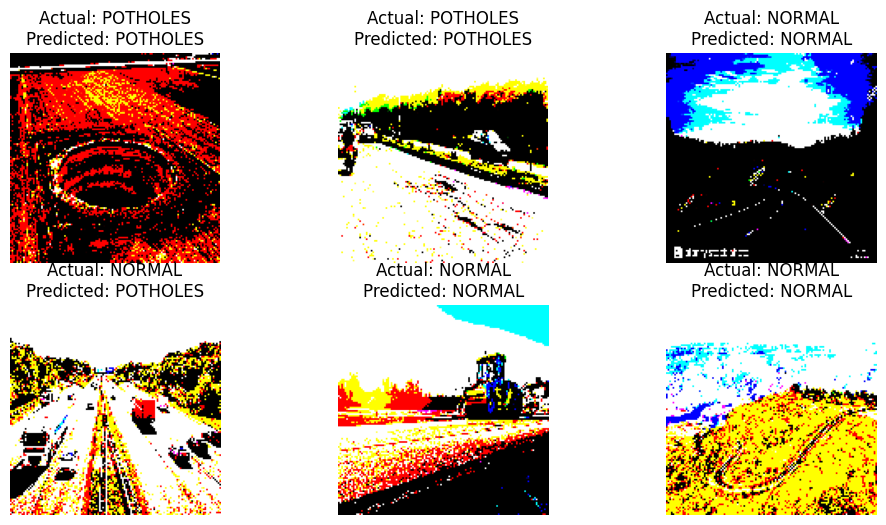

In [36]:
import random

# Assuming y_pred contains image data
# You may need to reshape or preprocess it as needed

# Create a figure to display images
plt.figure(figsize=(12, 6))

# Choose a random sample of test images to display
sample_indices = random.sample(range(len(X_test)), 6)

# Loop through the sample and display each image
for i, index in enumerate(sample_indices):
    plt.subplot(2, 3, i + 1)  # Create a 2x3 grid of subplots
    plt.imshow(X_test[index])  # Display the test image
    plt.title(f'Actual: {class_labels[y_test[index].argmax()]}\nPredicted: {class_labels[y_pred[index].argmax()]}')
    plt.axis('off')  # Turn off axis labels

plt.show()
